In [7]:
# importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
SEED = 80
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import os
import string
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/abhay/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
!pip install seaborn
!pip install nltk
!pip install wordcloud

     |████████████████████████████████| 220 kB 1.9 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp39-cp39-macosx_11_0_arm64.whl size=152132 sha256=a0b400ad83de1ecc0a065ced764989647be5c3db75dcf4b40ad67ddb16647988
  Stored in directory: /Users/abhay/Library/Caches/pip/wheels/f9/7a/dd/06ef8b5dfe5483f6204133c08eeb16c287cc2c05e290ae2fc0
Successfully built wordcloud


# 20 news group

In [8]:
# loading the data
newsgroups20_train = fetch_20newsgroups(subset='train',random_state=SEED, remove=('headers','footers','quotes'))
newsgroups20_test = fetch_20newsgroups(subset='test', random_state=SEED, remove=('headers','footers','quotes'))

In [9]:
# Take a look at the data:
newsgroups20_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [10]:
train_df = pd.DataFrame({'data': newsgroups20_train.data, 'target': newsgroups20_train.target})
train_df.head()

,data,target
0,\n\nThe SC1/SC2 has a shorter wheel base than ...,7
1,"\nWell, I'd say you're mostly right, but for d...",8
2,It sounds like a MAGNAVOX with a sick flyback ...,3
3,\nObviously some reporter for the Ottawa Sun g...,10
4,"\n\n Currently, there is a bill before the Te...",16


In [11]:
test_df = pd.DataFrame({'data': newsgroups20_test.data, 'target': newsgroups20_test.target})
test_df.head()

,data,target
0,Anyone have a price quote/vendor for the vx to...,4
1,"\n\nI quote from the journal, ""30 Days In the ...",15
2,: # #The median number of sexual partners for ...,18
3,I got a ET4000/W32 card which is made by Carde...,3
4,"\n\n\nIt is 'Serdar', 'kocaoglan'.\n\n\nJust s...",17


In [12]:
def plot_class_distribution(data, class_name, title):
    ax = sns.countplot(x=class_name, data=data)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right')
    plt.show()

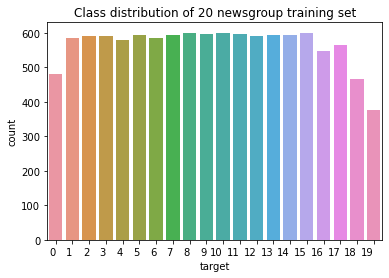

In [13]:
plot_class_distribution(train_df, 'target', "Class distribution of 20 newsgroup training set")

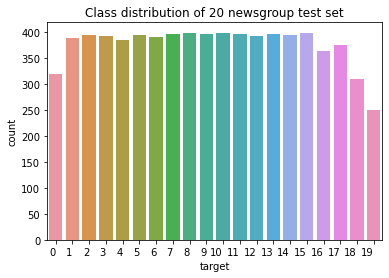

In [14]:
plot_class_distribution(test_df, 'target', "Class distribution of 20 newsgroup test set")

In [15]:
def wl(text):
    return len(text.split(" "))

In [16]:
def cl(text):
    return len(text)

In [17]:
train_df['word_count'] = train_df['data'].apply(wl)

In [18]:
train_df['character_count'] = train_df['data'].apply(cl)

In [19]:
def avg_wc(df, groupby_col, wc_col):
    return df.groupby([groupby_col])[wc_col].mean()

In [20]:
v = avg_wc(train_df, 'target', 'word_count')
# classes with most and the least word count
print(v.sort_values(ascending=False)[:3])
print(v.sort_values(ascending=True)[:3])

target
17    363.391844
18    332.894624
11    297.979832
Name: word_count, dtype: float64
target
8    111.770903
4    112.600346
2    113.539763
Name: word_count, dtype: float64


In [21]:
def text_preprocessing(text):
    alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())
    strip = lambda x: str.rsplit(x)
    remove_stopwords = lambda x: " ".join([w for w in x if w not in stopwords.words('english')])
    return text.map(alphanumeric).map(punc_lower).map(strip).map(remove_stopwords)

In [22]:
train_df_preprocessed = train_df.copy()
train_df_preprocessed.data = text_preprocessing(train_df_preprocessed.data)

In [23]:
train_df_preprocessed['preprocessed_wc'] = train_df_preprocessed['data'].apply(wl)

In [24]:
train_df_preprocessed['preprocessed_cc'] = train_df_preprocessed['data'].apply(cl)

In [25]:
v = avg_wc(train_df_preprocessed, 'target', 'preprocessed_wc')
# classes with most and the least word count after preprocessing
print(v.sort_values(ascending=False)[:3])
print(v.sort_values(ascending=True)[:3])

target
17    176.897163
11    146.771429
18    143.941935
Name: preprocessed_wc, dtype: float64
target
8    55.038462
4    55.717993
6    58.200000
Name: preprocessed_wc, dtype: float64


In [26]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [27]:
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
common_words = get_top_n_bigrams(train_df_preprocessed['data'], 10)
for word, freq in common_words:
    print(word, freq)

maxaxaxaxaxaxaxaxaxaxaxaxaxaxax maxaxaxaxaxaxaxaxaxaxaxaxaxaxax 2648
dont know 689
db db 520
dont think 355
im sure 354
mr stephanopoulos 341
united states 301
new york 278
thanks advance 241
years ago 236


#### Cleaning the bad data from bigrams

In [29]:
indices = []
for i, d in enumerate(train_df_preprocessed.data):
    if 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax' in d:
        indices.append(i)
    if 'db db' in d:
        indices.append(i)

In [30]:
train_df_preprocessed = train_df_preprocessed.drop(train_df_preprocessed.index[indices])

In [31]:
common_bigrams = get_top_n_bigrams(train_df_preprocessed['data'], 10)
for word, freq in common_bigrams:
    print(word, freq)

dont know 688
dont think 355
im sure 354
mr stephanopoulos 341
united states 301
new york 278
thanks advance 241
years ago 236
law enforcement 215
anonymous ftp 198


In [32]:
common_trigrams = get_top_n_trigrams(train_df_preprocessed['data'], 10)
for word, freq in common_trigrams:
    print(word, freq)

available anonymous ftp 105
gordon banks skepticism 74
banks skepticism chastity 74
skepticism chastity intellect 74
chastity intellect gebcadredslpittedu 73
intellect gebcadredslpittedu shameful 73
gebcadredslpittedu shameful surrender 73
shameful surrender soon 73
pts pt la 64
power play scorer 62


#### Visualizing bigrams and trigrams

<AxesSubplot:>

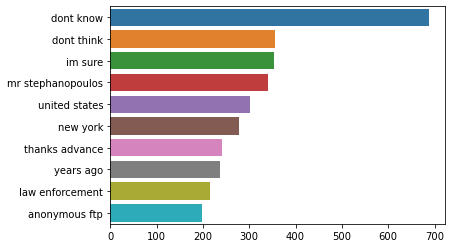

In [33]:
x,y = map(list,zip(*common_bigrams))
sns.barplot(x = y,y = x)

<AxesSubplot:>

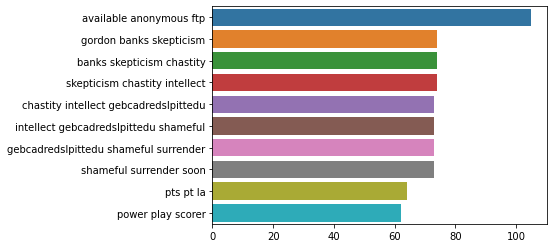

In [34]:
x,y = map(list,zip(*common_trigrams))
sns.barplot(x = y,y = x)

#### Kernel Density Plot

In [35]:
v = avg_wc(train_df_preprocessed, 'target', 'word_count')
print(v.sort_values(ascending=False)[:3])
print(v.sort_values(ascending=True)[:3])

target
17    363.391844
18    332.894624
11    290.461279
Name: word_count, dtype: float64
target
8    111.770903
4    112.608319
2    115.275387
Name: word_count, dtype: float64


In [36]:
def plot_kde(df, s_col):
    def wl(text):
        return len(text.split(" ")) % 100
    df['wl'] = df[s_col].apply(wl)
    cmap = get_cmap(20)
    sns.kdeplot(df[df['target']==17]['wl'],color=cmap(16))
    sns.kdeplot(df[df['target']==18]['wl'],color=cmap(13))
    sns.kdeplot(df[df['target']==11]['wl'],color=cmap(10))
    sns.kdeplot(df[df['target']==8]['wl'],color=cmap(7))
    sns.kdeplot(df[df['target']==4]['wl'],color=cmap(4))
    sns.kdeplot(df[df['target']==2]['wl'],color=cmap(1))
    plt.legend(['Class 16', 'Class 13', 'Class 10', 'Class 7', 'Class 4', 'Class 1'])
    plt.figure(figsize=(16, 12))
    plt.show()

In [37]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

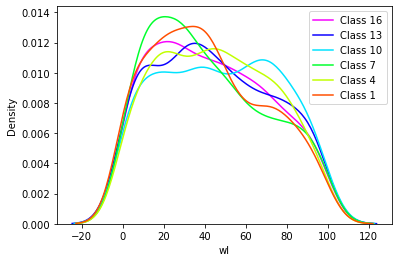

<Figure size 1152x864 with 0 Axes>

In [38]:
plot_kde(train_df, 'data') # Nothing meaningful here

#### Wordcloud

<AxesSubplot:>

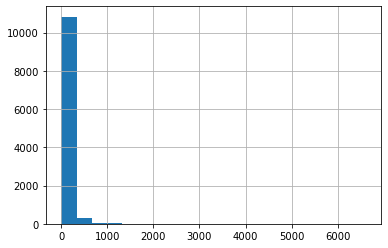

In [39]:
train_df_preprocessed.data.str.split().\
    map(lambda x: len(x)).\
    hist(bins=20)

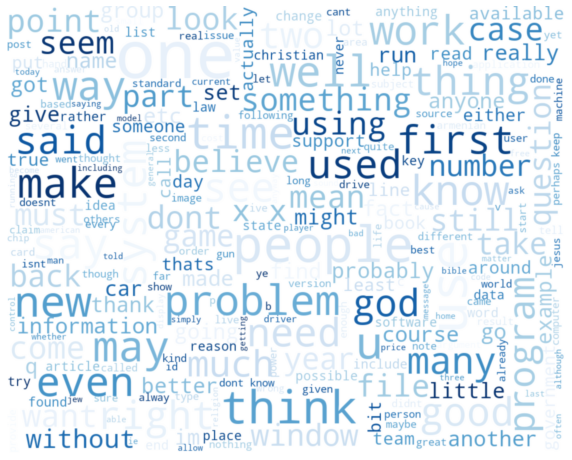

In [40]:
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 1000,  
                       min_word_length = 1, # From the histogram
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(train_df_preprocessed.data))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

#### Correlation Matrix

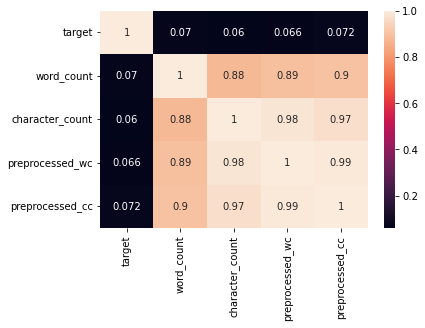

In [41]:
sns.heatmap(train_df_preprocessed.corr(), annot=True)
plt.show() # the statistical features have a poor correlation with the targer variable

# Sentiment 140

In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
header_list = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', names=header_list)

In [43]:
data

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [44]:
def plot_class_distribution(data, class_name, title):
    ax = sns.countplot(x=class_name, data=data)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right')
    plt.show()

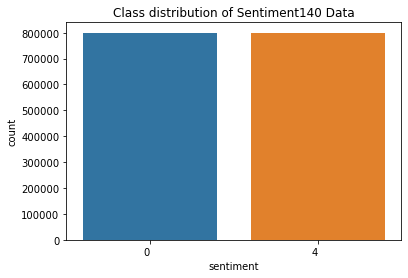

In [45]:
plot_class_distribution(data, 'sentiment', "Class distribution of Sentiment140 Data") # 4 is positve and 0 is negative

In [46]:
data['word_count'] = data['text'].apply(wl)

In [47]:
data['character_count'] = data['text'].apply(cl)

In [48]:
data_preprocessed = data.copy()
data_preprocessed.text = text_preprocessing(data_preprocessed.text)

In [49]:
data_preprocessed['preprocessed_wc'] = data_preprocessed['text'].apply(wl)
data_preprocessed['preprocessed_cc'] = data_preprocessed['text'].apply(cl)

In [50]:
data_preprocessed

,sentiment,ids,date,flag,user,text,word_count,character_count,preprocessed_wc,preprocessed_cc
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot httptwitpiccom awww thats bummer sh...,20,115,11,76
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...,22,111,12,74
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save re...,19,89,10,58
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire,11,47,6,32
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass behaving im mad cant see,22,111,6,40
...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever,12,56,5,29
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom cool hear old walt interviews â« ht...,12,78,8,54
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details,12,57,5,31
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy birthday boo alll time tupac amaru shakur,13,65,8,47


In [51]:
v = avg_wc(data_preprocessed, 'sentiment', 'word_count')
# classes with most and the least word count
print(v.sort_values(ascending=False)[:3])

sentiment
0    14.780492
4    13.983769
Name: word_count, dtype: float64


In [52]:
def plot_kde(df, s_col):
    cmap = get_cmap(20)
    sns.kdeplot(df[df['sentiment']==0]['preprocessed_wc'],color=cmap(10))
    sns.kdeplot(df[df['sentiment']==4]['preprocessed_wc'],color=cmap(1))
    plt.legend(['Class Negative', 'Class Positive'])
    plt.figure(figsize=(16, 12))
    plt.show()

In [53]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

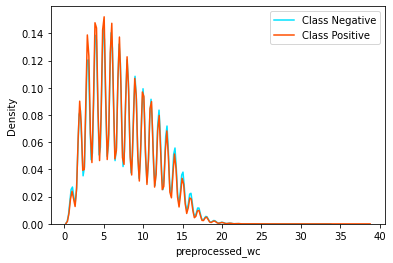

<Figure size 1152x864 with 0 Axes>

In [54]:
plot_kde(data_preprocessed, 'data')

In [55]:
common_bigrams = get_top_n_bigrams(data_preprocessed['text'], 10)
for word, freq in common_bigrams:
    print(word, freq)

im going 10770
good morning 9819
dont know 8817
feel like 6533
im gonna 6449
im sorry 6255
dont want 6034
looking forward 5547
looks like 5120
getting ready 4939


In [56]:
common_trigrams = get_top_n_trigrams(data_preprocessed['text'], 10)
for word, freq in common_trigrams:
    print(word, freq)

happy mothers day 2172
followers day using 1484
add train pay 1484
train pay vip 1484
mtv movie awards 1362
hope feel better 1071
im gonna miss 997
day using wwwtweeteraddercom 830
using wwwtweeteraddercom add 830
wwwtweeteraddercom add train 830


<AxesSubplot:>

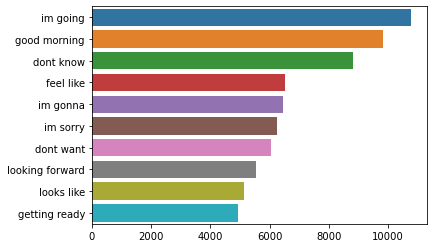

In [57]:
x,y = map(list,zip(*common_bigrams))
sns.barplot(x = y,y = x)

<AxesSubplot:>

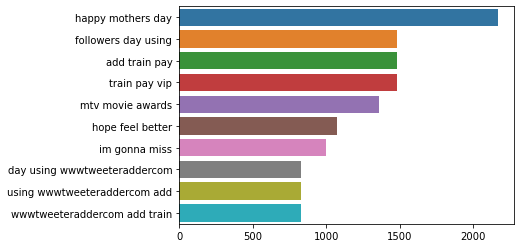

In [58]:
x,y = map(list,zip(*common_trigrams))
sns.barplot(x = y,y = x)

<AxesSubplot:>

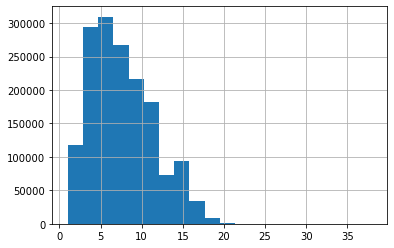

In [59]:
data_preprocessed.preprocessed_wc.hist(bins=20) # this is a bimodal distribution based on the word count

<AxesSubplot:>

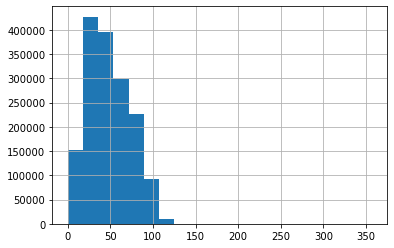

In [60]:
data_preprocessed.preprocessed_cc.hist(bins=20) 

In [61]:
positive = data_preprocessed[data_preprocessed.sentiment == 0]
negative = data_preprocessed[data_preprocessed.sentiment == 4]

<AxesSubplot:>

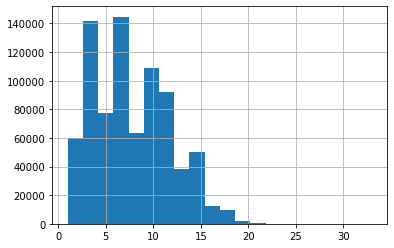

In [62]:
positive.preprocessed_wc.hist(bins=20)

<AxesSubplot:>

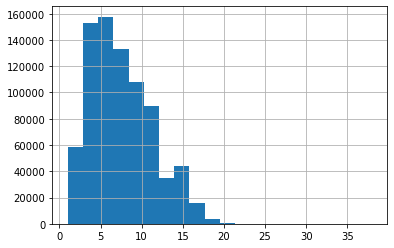

In [63]:
negative.preprocessed_wc.hist(bins=20)

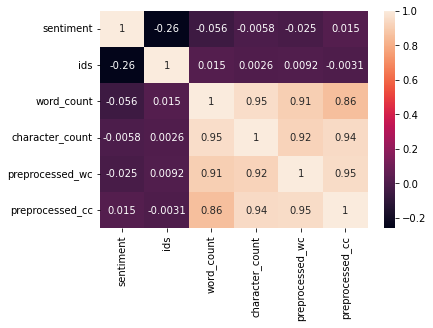

In [64]:
sns.heatmap(data_preprocessed.corr(), annot=True)
plt.show() # Again there is no large correlation with the statistical features

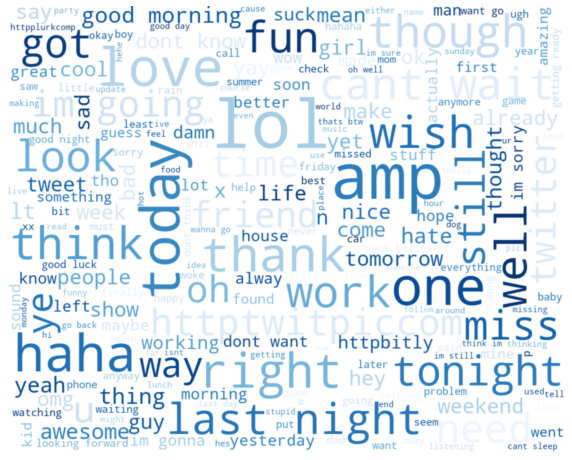

In [65]:
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 1000,  
                       min_word_length = 1, # From the histogram
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(data_preprocessed.text))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show() # we see same words in our bigrams and trigrams